In [1]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
  inflating: test.tsv                
  inflating: train.tsv               
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
2023-10-07 05:20:06.397216: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-07 05:20:07.422965: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-07 05:20:08.803207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10

Тут придется авторизировать запрос к гугл драйву, извините.

In [2]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d1-5FwxK53ePwygNWeG7jhsOWZbi5HOv'})
downloaded.GetContentFile('train_docs.pkl')

downloaded = drive.CreateFile({'id': '1MMOY477t965G0C5DtXeREVp0X85UaNq5'})
downloaded.GetContentFile('test_docs.pkl')

# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [8]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [9]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [10]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [11]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

Применим ее:

In [12]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

Пора переходить к машинке!

Как будем представлять текст? Проще всего - мешком слов.

Заведём большой-большой словарь - список всех слов в обучающей выборке. Тогда каждое предложение можно представить в виде вектора, в котором будет записано, сколько раз встретилось каждое из возможных слов:

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

Простой и приятный способ сделать это - запихнуть тексты в `CountVectorizer`.

Он имеет такую сигнатуру:

```python
CountVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern=r'(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class ‘numpy.int64'>)
```

Для начала обратим внимание на параметры `lowercase=True` и `max_df=1.0, min_df=1, max_features=None` - они про то, что по умолчанию все слова будут приводиться к нижнему регистру и в словарь попадут все слова, встречавшиеся в текстах.

При желании можно было бы убрать слишком редкие или слишком частотные слова - пока не будем этого делать.

Посмотрим на простом примере, как он будет работать:

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names_out())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful' 'excellent' 'movie' 'the' 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [15]:
vectorizer.get_feature_names_out()

array(['00', '000', '0000000000001', ..., 'østbye', 'über', 'üvegtigris'],
      dtype=object)

Попробуем кого-нибудь таки сконвертировать

In [16]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

То, что и хотели - вектор с bow (т.е. bag-of-words) представлением исходного текста.

И чем эта информация может помочь? Ну, всё тем же - какие-то слова носят положительный окрас, какие-то - отрицательный. Большинство вообще нейтральный, да.

![bow with weights](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2001/Images/BOW_weights.png)

Хочется, наверное, подобрать коэффициенты, которые будут определять уровень окраса, да? Подбирать нужно по обучающей выборке, а не как мы перед этим делали.

Например, для выборки
```
1   The movie was excellent
0   the movie was awful
```
легко подобрать коэффициенты на глазок: что-нибудь вроде `+1` для `excellent`,  `-1` для `awful` и по нулям всем остальным.

Построим линейную модель, которая станет этим заниматься. Она будет учиться строить разделяющую гиперплоскость в пространстве bow-векторов.

Проверим, как справится логистическая регрессия с нашей супер-выборкой из пары предложений

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names_out())
print(classifier.coef_)

['awful' 'excellent' 'movie' 'the' 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [18]:
model.fit(train_df['review'], train_df['is_positive'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [19]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))

eval_model(model, test_df)

Test accuracy = 86.51%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [20]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.863,x54378
+1.771,x73498
+1.701,x26380
+1.656,x64644
+1.635,x53544
+1.440,x64397
+1.385,x22912
+1.373,x33223
+1.339,x49221
+1.307,x17335


Посмотрим на конкретные примеры его работы:

In [21]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer,
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [22]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer,
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [23]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


In [26]:
vectorizer = TfidfVectorizer(ngram_range=(1, 5))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.28%


**Вывод**: Изменение ngram_range может быть полезным в зависимости от задачи. Например, использование более широкого диапазона, такого как (1, 5), может помочь учесть контекст и связь между словами в тексте. Однако это также может увеличить размер векторов и усложнить модель. В рассматриваемом случае увелечение диапазона не привела к значимым результатам, а наоборот снизило качество метрики.



### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

              precision    recall  f1-score   support

           0       0.87      0.86      0.86     12500
           1       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Confusion Matrix:
[[10701  1799]
 [ 1632 10868]]


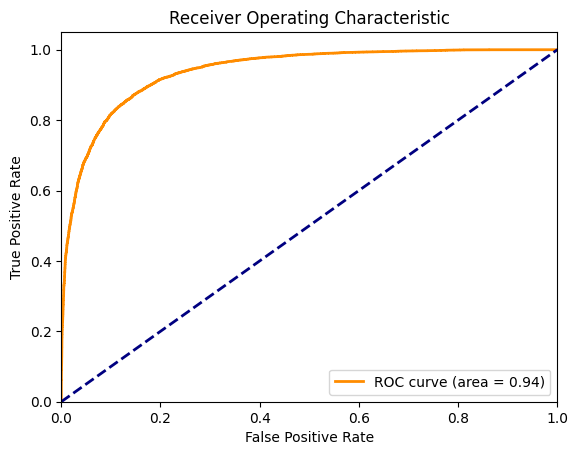

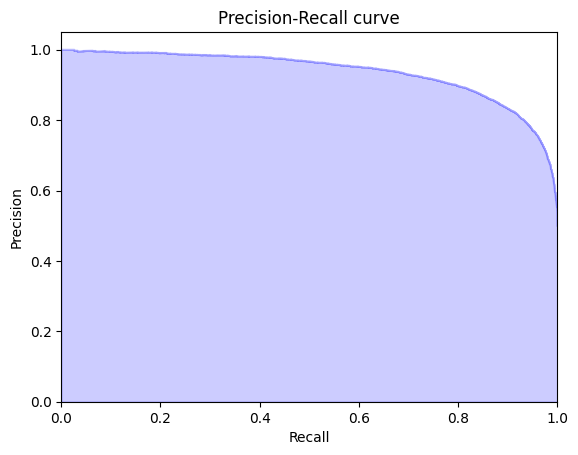

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Обучение модели
model.fit(train_df['review'], train_df['is_positive'])

# Оценка модели на тестовых данных
y_pred = model.predict(test_df['review'])

# Отчет о классификации
print(classification_report(test_df['is_positive'], y_pred))

# Матрица ошибок
confusion_mat = confusion_matrix(test_df['is_positive'], y_pred)
print("Confusion Matrix:")
print(confusion_mat)

# ROC-кривая и AUC
y_pred_prob = model.predict_proba(test_df['review'])[:, 1]
fpr, tpr, thresholds = roc_curve(test_df['is_positive'], y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(test_df['is_positive'], y_pred_prob)

plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()


In [28]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test accuracy = 87.86%


In [ ]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer,
                     targets=['positive'], target_names=['negative', 'positive'])

## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [30]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Весь этот процесс очень долгий, поэтому я предподсчитал всё.

In [33]:
import pickle

with open('train_docs.pkl', 'rb') as f:
    train_docs = pickle.load(f)

with open('test_docs.pkl', 'rb') as f:
    test_docs = pickle.load(f)

**Задание** Сделайте классификатор на лемматизированных текстах.

In [73]:
# Подготовка данных

X_train = []
for doc in docs:
    doc_data = [(token.text, token.ent_iob_, token.ent_type_) for token in doc]
    X_train.append(doc_data)

X_test = []
for doc in docs:
    doc_data = [(token.text, token.ent_iob_, token.ent_type_) for token in doc]
    X_test.append(doc_data)

# Преобразование данных X_train в список строк
X_train_texts = [' '.join([' '.join(data) for data in doc_data]) for doc_data in X_train]

# Преобразование данных X_test в список строк
X_test_texts = [' '.join([' '.join(data) for data in doc_data]) for doc_data in X_test]

# Примените TF-IDF векторизацию к текстовым данным
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

In [ ]:
X_train[0]

In [74]:
# Инициализация пустых списков для меток
y_train = []
y_test = []

# Идем по каждому документу и извлекаем метки
for doc in X_train:
    labels = [label for _, label, _ in doc]
    y_train.append(labels)

for doc in X_test:
    labels = [label for _, label, _ in doc]
    y_test.append(labels)

In [75]:
from sklearn.preprocessing import MultiLabelBinarizer

# Создаем экземпляр MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Преобразовываем списки меток в бинарный формат
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

# Преобразовываем бинарные метки в одномерные массивы
y_train_flattened = y_train_binary.argmax(axis=1)
y_test_flattened = y_test_binary.argmax(axis=1)

# Обучение модели (логистической регрессии)
classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train_tfidf, y_train_flattened)

# Предсказание меток для тестовых данных
y_pred_flattened = classifier.predict(X_test_tfidf)

# Оценка производительности модели
accuracy = accuracy_score(y_test_flattened, y_pred_flattened)
classification_report_output = classification_report(y_test_flattened, y_pred_flattened)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_output)

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           2       0.00      0.00      0.00         1

    accuracy                           0.98        50
   macro avg       0.49      0.50      0.49        50
weighted avg       0.96      0.98      0.97        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [60]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [76]:
# Подготовка данных

X_train = []
for doc in docs:
    doc_data = [(token.text, token.ent_iob_, token.ent_type_, token.head.text) for token in doc]
    X_train.append(doc_data)

X_test = []
for doc in docs:
    doc_data = [(token.text, token.ent_iob_, token.ent_type_, token.head.text) for token in doc]
    X_test.append(doc_data)

# Преобразование данных X_train в список строк
X_train_texts = [' '.join([' '.join(data) for data in doc_data]) for doc_data in X_train]

# Преобразование данных X_test в список строк
X_test_texts = [' '.join([' '.join(data) for data in doc_data]) for doc_data in X_test]

# Примените TF-IDF векторизацию к текстовым данным
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)
X_test_tfidf = tfidf_vectorizer.transform(X_test_texts)

# Инициализация пустых списков для меток
y_train = []
y_test = []

# Идем по каждому документу и извлекаем метки
for doc in X_train:
    labels = [label for _, label, _, _ in doc]
    y_train.append(labels)

for doc in X_test:
    labels = [label for _, label, _, _ in doc]
    y_test.append(labels)

from sklearn.preprocessing import MultiLabelBinarizer

# Создаем экземпляр MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Преобразовываем списки меток в бинарный формат
y_train_binary = mlb.fit_transform(y_train)
y_test_binary = mlb.transform(y_test)

# Преобразовываем бинарные метки в одномерные массивы
y_train_flattened = y_train_binary.argmax(axis=1)
y_test_flattened = y_test_binary.argmax(axis=1)

# Обучение модели (логистической регрессии)
classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train_tfidf, y_train_flattened)

# Предсказание меток для тестовых данных
y_pred_flattened = classifier.predict(X_test_tfidf)

# Оценка производительности модели
accuracy = accuracy_score(y_test_flattened, y_pred_flattened)
classification_report_output = classification_report(y_test_flattened, y_pred_flattened)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report_output)


Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           2       0.00      0.00      0.00         1

    accuracy                           0.98        50
   macro avg       0.49      0.50      0.49        50
weighted avg       0.96      0.98      0.97        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Вывод**:

Результаты классификации текста с использованием базовых форм слов оказались такими же, как при использовании лемм, это может иметь несколько причин:

1. Зависимость модели от контекста: Модель логистической регрессии, используемая в вашем коде, может не обнаруживать существенной разницы между леммами и базовыми формами слов, особенно если контекст предоставляет однозначные признаки для классификации.

2. Качество базовых форм: Если базовые формы слов не значительно отличаются от лемм или не добавляют новой информации, это также может привести к схожим результатам. В зависимости от языка и текстовых данных, разница между леммами и базовыми формами может быть не такой значительной.

3. Выбор модели: Модель логистической регрессии является линейной моделью и может оказаться ограниченной в способности улавливать сложные зависимости в данных. Возможно, для более точной классификации вам потребуется использовать более сложные модели, такие как метод опорных векторов (SVM), случайный лес или нейронные сети.

4. Размер датасета и данных: Если ваш датасет небольшой или данные слишком схожи, то даже небольшие различия между леммами и базовыми формами могут быть недостаточными для улучшения производительности модели.

Для улучшения производительности модели, можно попробовать следующие шаги:

- Попробовать более сложные модели машинного обучения.
- Увеличить размер и разнообразие вашего датасета.
- Исследовать другие признаки или методы предварительной обработки текста, которые могут улучшить различие между леммами и базовыми формами слов.

Важно также проверить качество разметки данных и правильность применения базовых форм слов.

Для улучшения производительности классификации текста, попробовала использовать другую модель машинного обучения - метод опорных векторов (Support Vector Machine, SVM), который может быть эффективным для задач классификации текста.



In [77]:
from sklearn.svm import SVC

# Инициализируем модель SVM
svm_classifier = SVC()

# Обучение модели
svm_classifier.fit(X_train_tfidf, y_train_flattened)

# Предсказание меток для тестовых данных
y_pred_svm = svm_classifier.predict(X_test_tfidf)

# Оценка производительности модели SVM
accuracy_svm = accuracy_score(y_test_flattened, y_pred_svm)
classification_report_svm = classification_report(y_test_flattened, y_pred_svm)

print("Accuracy (SVM):", accuracy_svm)
print("\nClassification Report (SVM):\n", classification_report_svm)

Accuracy (SVM): 0.98

Classification Report (SVM):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           2       0.00      0.00      0.00         1

    accuracy                           0.98        50
   macro avg       0.49      0.50      0.49        50
weighted avg       0.96      0.98      0.97        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


После того как была применена другая модель машинного обучения, но результаты остаются теми же, можно предположить следующие возможные причины:

1. **Качество данных:** Возможно, проблема связана с качеством и разнообразием данных.

2. **Гиперпараметры модели:** Результаты могут зависеть от выбора гиперпараметров модели.

3. **Инженерия признаков:** Рассмотрите возможность более сложной инженерии признаков, которая может помочь модели лучше выявлять паттерны.

4. **Исследование модели:** Попробуйте другие модели машинного обучения, такие как случайные леса, градиентный бустинг или нейронные сети.

5. **Размер обучающей выборки:** Увеличение размера обучающей выборки иногда может улучшить результаты, если данных недостаточно.

6. **Проверка переобучения:** Возможно, что модель переобучается на обучающих данных.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [78]:
import spacy
from spacy import displacy

In [79]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [80]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<BarContainer object of 231 artists>

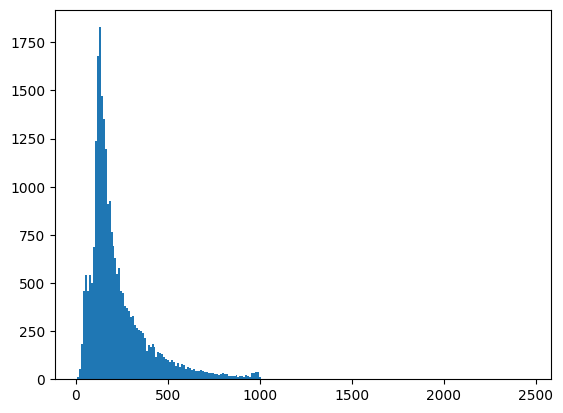

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [82]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break

    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [83]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)

    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

<ipython-input-83-c9a010e72594>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
<ipython-input-83-c9a010e72594>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Depreca

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train,
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [84]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [85]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [86]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1714883 (6.54 MB)
Trainable params: 1714883 (6.54 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [87]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10,
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 49s 218ms/step - loss: 0.6107 - accuracy: 0.6840 - val_loss: 0.4504 - val_accuracy: 0.8484
Epoch 2/10
196/196 [==============================] - 36s 181ms/step - loss: 0.3173 - accuracy: 0.8848 - val_loss: 0.3002 - val_accuracy: 0.8747
Epoch 3/10
196/196 [==============================] - 24s 122ms/step - loss: 0.1728 - accuracy: 0.9385 - val_loss: 0.3017 - val_accuracy: 0.8746
Epoch 4/10
196/196 [==============================] - 19s 95ms/step - loss: 0.0910 - accuracy: 0.9734 - val_loss: 0.3345 - val_accuracy: 0.8729
Epoch 5/10
196/196 [==============================] - 18s 93ms/step - loss: 0.0411 - accuracy: 0.9915 - val_loss: 0.3823 - val_accuracy: 0.8688
Epoch 6/10
196/196 [==============================] - 19s 97ms/step - loss: 0.0176 - accuracy: 0.9980 - val_loss: 0.4259 - val_accuracy: 0.8665
Epoch 7/10
196/196 [==============================] - 14s 69ms/step - loss: 0.0085 - accuracy: 0.9992 - val_loss: 0.4600 - val_accura

**Задание** Подсчитайте качество модели на тесте

In [88]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Получение прогнозов модели для тестовой выборки
y_pred = model.predict(X_test)
# Округление вероятности до 0 или 1 (если вероятность >= 0.5, то класс 1, в противном случае - класс 0)
y_pred = (y_pred >= 0.5).astype(int)

# Оценка точности
accuracy = accuracy_score(test_df.is_positive, y_pred)
print("Accuracy:", accuracy)

# Отчет о классификации (precision, recall, F1-мера)
classification_rep = classification_report(test_df.is_positive, y_pred)
print("Classification Report:\n", classification_rep)

# Матрица ошибок (confusion matrix)
confusion_mtx = confusion_matrix(test_df.is_positive, y_pred)
print("Confusion Matrix:\n", confusion_mtx)

782/782 [==============================] - 2s 2ms/step
Accuracy: 0.86372
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.88      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Confusion Matrix:
 [[10617  1883]
 [ 1524 10976]]
